In [18]:
import sys

import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib notebook
## save variables
import pickle
## folder names
from glob import glob
## standard libraries
import numpy as np

##
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import normalize


#!{sys.executable} -m pip install tensorflow-gpu --user
#!{sys.executable} -m pip install keras --user
import tensorflow as tf
from keras import backend as k

import keras
from keras.optimizers import SGD, Adam
#!{sys.executable} -m pip install hyperas --user
#!{sys.executable} -m pip install networkx==1.11 --user

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe

import os.path
import datetime

from dependencies import models
from dependencies import functions

from dependencies.convnet_drawer.convnet_drawer import Model
from dependencies.convnet_drawer.convnet_drawer import Conv2D
from dependencies.convnet_drawer.convnet_drawer import MaxPooling2D as MaxPooling2D_drawer
from dependencies.convnet_drawer.convnet_drawer import Flatten as Flatten_drawer
from dependencies.convnet_drawer.convnet_drawer import Dense as Dense_drawer
from dependencies.convnet_drawer.matplotlib_util import save_model_to_file
from dependencies.convnet_drawer.keras_util import convert_drawer_model

# Import mfcc data

In [14]:
#choose which dictionary to use
choice =  'logfilter' # 'mfcc'#
useDelta = False
#retrieving of used values for the computation of mfcc
with open('variables/mfccValues.pkl', 'rb') as f:  
    values = pickle.load(f)
selected = 0
if choice == 'mfcc':
    
    
    
    #name format of the selected data
    if useDelta:
        name = 'variables/mfcc_D_DD_Dict[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    else:
        name = 'variables/mfccDict[nC='+str(values[selected][0])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    #loading in usedDict of the mfcc dict
    #name = 'variables/mfcc_delta_deltadelta_PCA.pkl'
    with open(name, 'rb') as f: 
        usedDict = pickle.load(f)
    print('Loaded '+name)

elif choice == 'logfilter':
    name = 'variables/logfiltDict[nF='+str(values[selected][1])+' wL='+str(values[selected][2])+' wS='+str(values[selected][3])+'].pkl'
    #name = 'variables/pcalogDict.pkl'
    #saving in usedDict of the logfilter dict
    with open(name, 'rb') as f:  
        usedDict = pickle.load(f)
    print('Loaded '+name)

Loaded variables/logfiltDict[nF=26 wL=0.025 wS=0.01].pkl


# Acquiring and scaling data

In [137]:
%%time
#core words of the dataset
coreKey = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero",
           "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#split of the core set
numbers = ['one', 'two', 'three','four','five','six','seven','eight','nine', "zero"]

words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

test = ["yes", "up", "down", "left"]#, "right", "on", "off", "stop", "go", "zero",
          # "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

#selecting the subset of words
used = coreKey

used.append('silence')
'''
unknown = list(usedDict.keys())
for key in used:
    try:
        unknown.remove(key)
    except:
        print(key, ' not in used')
'''



Wall time: 0 ns


In [ ]:
#divding between train and test with also scaling data

functions.train_test_creator(
    {k: usedDict[k] for k in usedDict.keys() & used },
    {k: usedDict[k] for k in usedDict.keys() & unknown },
    with_unknown = True,
    scalerType = 'robust',
    depth = 3)

In [17]:
%reset -f
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([0])")

<IPython.core.display.Javascript object>

In [19]:
x_train, y_train, x_test, y_test = functions.data()
with open('variables/labelList.pkl', 'rb') as f: 
        labelList = pickle.load(f)

# Fitting

In [20]:
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total 0.9 of the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.8
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

epoch = 40
epochSGD = 20

dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)

tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

In [ ]:
cnn = models.model1(x_train,y_train, depth = 3)
print("Model1")
cnn.summary()

cnn = models.model2(x_train,y_train, depth = 3)
print("Model2")
cnn.summary()

cnn = models.model3(x_train,y_train, depth = 3)
print("Model3")
cnn.summary()

cnn = models.tinyDarknet(x_train,y_train, depth = 3)
print("tiny darknet")
cnn.summary()

In [ ]:
%%time

print("MODEL1")
cnn = models.model1(x_train,y_train, depth = x_train.shape[3])

cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/300),
                     shuffle=True,
                     callbacks = [tbCallBack])

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/300), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width


plt.show()

name = 'cnn1.bak'
cnn.save(dest_directory + name)

In [ ]:
%%time
print("\nMODEL3")
cnn = models.model3(x_train,y_train, depth = 3, basedim = 32)

cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/200),
                     shuffle=True,
                     callbacks = [tbCallBack])

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/200), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

name = 'cnn3.bak'
cnn.save(dest_directory + name)

In [11]:
%%time
print("\nTINYDARKNET")
cnn = models.tinyDarknet(x_train,y_train, depth = 3, dropout = 0.05)
#cnn.summary()


compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
fittedAdam = cnn.fit(x_train, y_train,
                     epochs=epoch,
                     validation_data=(x_test, y_test),
                     batch_size=round(x_train.shape[0]/200),
                     shuffle=True,
                     callbacks = [tbCallBack])

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

fittedSGD = cnn.fit(x_train, y_train, 
                epochs=epochSGD, 
                validation_data=(x_test, y_test), 
                batch_size=round(x_train.shape[0]/200), 
                shuffle=True,
                callbacks = [tbCallBack])

fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

fig, ax = plt.subplots()
x = range(epochSGD)
for key in fittedSGD.history:
    ax.plot(x,fittedSGD.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
    
plt.show()

name = 'cnn4.bak'
cnn.save(dest_directory + name)


TINYDARKNET
Train on 39418 samples, validate on 9855 samples
Epoch 1/40
39418/39418 [==============================] - 32s 819us/step - loss: 1.7392 - acc: 0.6465 - val_loss: 0.6877 - val_acc: 0.8301
Epoch 2/40
39418/39418 [==============================] - 27s 694us/step - loss: 0.4624 - acc: 0.8777 - val_loss: 0.4096 - val_acc: 0.8908
Epoch 3/40
39418/39418 [==============================] - 27s 694us/step - loss: 0.3358 - acc: 0.9080 - val_loss: 0.3657 - val_acc: 0.9013
Epoch 4/40
39418/39418 [==============================] - 27s 694us/step - loss: 0.3069 - acc: 0.9173 - val_loss: 0.5289 - val_acc: 0.8636
Epoch 5/40
39418/39418 [==============================] - 27s 694us/step - loss: 0.3132 - acc: 0.9178 - val_loss: 0.3222 - val_acc: 0.9143
Epoch 6/40
39418/39418 [==============================] - 27s 696us/step - loss: 0.2610 - acc: 0.9298 - val_loss: 0.3166 - val_acc: 0.9154
Epoch 7/40
39418/39418 [==============================] - 27s 695us/step - loss: 0.2504 - acc: 0.9344 - 

KeyboardInterrupt: 

In [ ]:
#!tensorboard --logdir Graph/

In [125]:
from keras.layers import Input
from keras.layers import Flatten, Dense, Activation, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, AveragePooling2D
from keras import regularizers
input_img = Input(name = 'input', shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]))

def cBN(inputLayer, filt = 25, size = (1,1), padding = 'same', activation = 'relu', regu = 0.0, dropout = 0.1):
    cbn = Conv2D(filt, size, padding=padding, use_bias=True, kernel_regularizer=regularizers.l2(regu))(inputLayer)
    #cbn = BatchNormalization()(cbn)
    cbn = Activation(activation)(cbn)
    cbn = Dropout(dropout)(cbn)
    return cbn

def inception(inputLayer):
    tower_1 = cBN(inputLayer)   
    tower_1 = cBN(tower_1, size = (3,3))

    tower_2 = cBN(inputLayer)
    tower_2 = cBN(tower_2, size = (5,5))

    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(inputLayer)
    tower_3 = cBN(tower_3)
    
    tower_4 = cBN(inputLayer)

    output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis = 3)
    return output


def extraClassifier(name, inputLayer, outputShape):
    output0 = AveragePooling2D(pool_size=(5,4), strides=(3,3))(inputLayer)
    output0 = cBN(output0)
    output0 = Flatten()(output0)
    output0 = Dense(200)(output0)
    cbn = Dropout(0.7)(output0)
    output0 = Dense( outputShape, name = name, activation='softmax')(output0)
    return output0


output = cBN(input_img)
output = cBN(output, size = (3,3))
output = cBN(output)
output = cBN(output, size = (3,3))

output = MaxPooling2D(pool_size=(2,2), padding='same')(output)

output = inception(output)
output = inception(output)

output = MaxPooling2D(pool_size=(2,2), padding='same')(output)

output = inception(output)

output0 = extraClassifier('output0', output, y_train.shape[1])
                
output = inception(output)

output = MaxPooling2D(pool_size=(2,2), padding='same')(output)

output = inception(output)
output1 = extraClassifier('output1',output, y_train.shape[1])
output = inception(output)

output = AveragePooling2D(pool_size=(7,2), padding='same')(output)

output = Flatten()(output)
output = BatchNormalization()(output)
output = Dense(100, activation = 'relu')(output)
output = BatchNormalization()(output)
output2= Dense(y_train.shape[1], name = 'output2', activation='softmax')(output)

In [126]:
from keras.models import Model
cnn = Model(inputs = input_img, outputs = [output2, output1, output0])
#cnn.summary()

In [131]:
sgd = SGD(lr=0.005, decay=0.0005, momentum=0.9, nesterov=True)
compiledSGD = cnn.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])
fittedSGD = cnn.fit(x_train, [y_train, y_train, y_train],
                     epochs=epoch,
                     batch_size=round(x_train.shape[0]/400),
                     shuffle=True,
                     callbacks = [tbCallBack])

Epoch 1/40
67432/67432 [==============================] - 52s 768us/step - loss: 0.5144 - output2_loss: 0.1355 - output1_loss: 0.1704 - output0_loss: 0.2085 - output2_acc: 0.9577 - output1_acc: 0.9481 - output0_acc: 0.9344
Epoch 2/40
67432/67432 [==============================] - 47s 702us/step - loss: 0.4905 - output2_loss: 0.1303 - output1_loss: 0.1625 - output0_loss: 0.1976 - output2_acc: 0.9597 - output1_acc: 0.9510 - output0_acc: 0.9385
Epoch 3/40
67432/67432 [==============================] - 47s 703us/step - loss: 0.4769 - output2_loss: 0.1258 - output1_loss: 0.1573 - output0_loss: 0.1938 - output2_acc: 0.9606 - output1_acc: 0.9520 - output0_acc: 0.9394
Epoch 4/40
67432/67432 [==============================] - 47s 703us/step - loss: 0.4665 - output2_loss: 0.1240 - output1_loss: 0.1542 - output0_loss: 0.1884 - output2_acc: 0.9611 - output1_acc: 0.9528 - output0_acc: 0.9410
Epoch 5/40
67432/67432 [==============================] - 48s 706us/step - loss: 0.4641 - output2_loss: 0.12

KeyboardInterrupt: 

In [130]:
Adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
validation_data=({'input': x_train} 
                 {'output0': y_train, 'output1': y_train, 'output2': y_train})
compiledAdam = cnn.compile(loss="categorical_crossentropy", optimizer=Adam, metrics=['accuracy'], loss_weights={'output0': 0.4, 'output1': 0.4, 'output2' : 1.})
fittedAdam = cnn.fit(x_train, [y_train, y_train, y_train],
                     epochs=epoch,
                     batch_size=round(x_train.shape[0]/400),
                     shuffle=True,
                     callbacks = [tbCallBack])
#validation_data=(x_test, y_test), 

Epoch 1/40
67432/67432 [==============================] - 57s 838us/step - loss: 5.7056 - output2_loss: 1.7196 - output1_loss: 1.9953 - output0_loss: 1.9908 - output2_acc: 0.4922 - output1_acc: 0.3964 - output0_acc: 0.4058
Epoch 2/40
67432/67432 [==============================] - 48s 718us/step - loss: 2.2130 - output2_loss: 0.6117 - output1_loss: 0.7925 - output0_loss: 0.8088 - output2_acc: 0.8158 - output1_acc: 0.7554 - output0_acc: 0.7537
Epoch 3/40
67432/67432 [==============================] - 48s 714us/step - loss: 1.6106 - output2_loss: 0.4437 - output1_loss: 0.5785 - output0_loss: 0.5884 - output2_acc: 0.8652 - output1_acc: 0.8256 - output0_acc: 0.8202
Epoch 4/40
67432/67432 [==============================] - 48s 717us/step - loss: 1.3780 - output2_loss: 0.3779 - output1_loss: 0.4900 - output0_loss: 0.5101 - output2_acc: 0.8862 - output1_acc: 0.8532 - output0_acc: 0.8467
Epoch 5/40
67432/67432 [==============================] - 48s 716us/step - loss: 1.2292 - output2_loss: 0.33

KeyboardInterrupt: 

# Score

In [134]:
#find prediction with test data
preds = cnn.predict(x_test)
#print(list(used))

[array([[1.1803324e-06, 2.5102824e-07, 2.2509793e-07, ..., 8.4184137e-08,
        4.4192580e-05, 1.6890455e-05],
       [2.7502009e-03, 7.6874003e-06, 3.4015062e-03, ..., 1.7009219e-04,
        7.5683020e-05, 1.5681600e-02],
       [8.3503965e-04, 3.7335612e-05, 1.0620064e-04, ..., 5.1224261e-04,
        9.9091715e-01, 3.4947353e-04],
       ...,
       [2.0194204e-06, 3.0601157e-09, 1.1737047e-06, ..., 4.5189729e-08,
        4.7789626e-08, 4.1717211e-08],
       [1.6905110e-02, 1.9623920e-04, 3.1151621e-06, ..., 9.4249141e-01,
        5.8251447e-07, 5.9707396e-05],
       [2.0766235e-09, 2.8346375e-07, 7.8178552e-08, ..., 4.5427438e-08,
        8.7512008e-06, 1.5501351e-07]], dtype=float32), array([[2.6027968e-11, 1.0747725e-11, 1.3192768e-08, ..., 2.2400001e-12,
        2.6336465e-05, 6.3920124e-05],
       [9.4995573e-03, 5.5536302e-06, 5.8913366e-03, ..., 3.1478540e-04,
        6.1602987e-05, 7.4628331e-02],
       [1.0055647e-04, 2.8105933e-04, 6.0214429e-06, ..., 1.3537063e-05,
 

<IPython.core.display.Javascript object>


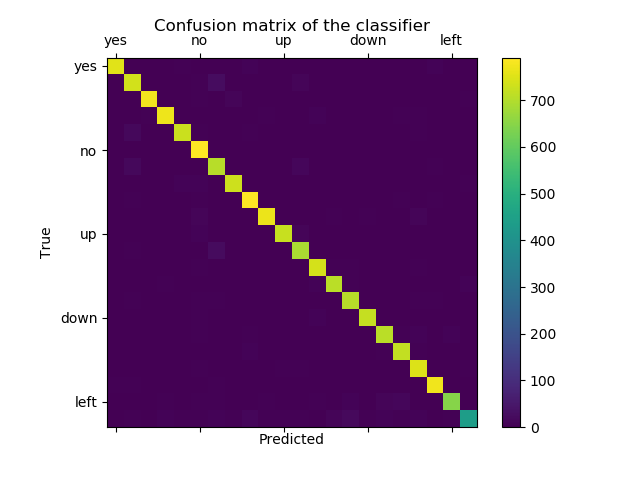

16858/16858 [==============================] - 8s 501us/step


In [139]:
#plot confusion matrix
functions.plotConfusionMatrix(preds[0],y_test,list(used))
precision = cnn.evaluate(x_test,[y_test,y_test,y_test])
#print ("Precision: ", round(precision*100,2),"%")

In [140]:
precision

[0.6206341283164962,
 0.19433871649827966,
 0.2025214799286802,
 0.22377393152513939,
 0.9421639577224311,
 0.9424605528108165,
 0.9340965713678496]

In [ ]:
fig, ax = plt.subplots()
x = range(epoch)
for key in fittedAdam.history:
    ax.plot(x,fittedAdam.history[key],label=key)
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

plt.show()
    

# Output of conv2D

In [ ]:
cnn_copy = Sequential()
cnn_copy.add(cnn.layers[0])
result = cnn_copy.predict(x_test)


In [ ]:
plt.figure()
plt.imshow(result[0,:,:,0])

# Save Model

In [ ]:
dest_directory = 'model_backup/'
if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)
name = 'cnn.bak'
cnn.save(dest_directory + name)

#bak = load_model(dest_directory + name)


In [ ]:
model = Model(input_shape=(x_train.shape[1], x_train.shape[2],1))
model.add(Conv2D(100, (4,4),  strides = (1,1), padding="valid"))
model.add(Conv2D(100, (4,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(3,3)))
model.add(Conv2D(128, (4,2),  strides = (1,1), padding="valid"))
model.add(Conv2D(128, (5,2),  strides = (1,1), padding="valid"))
model.add(MaxPooling2D_drawer(pool_size=(4,1)))
model.add(Flatten_drawer())
model.add(Dense_drawer(100))
model.add(Dense_drawer(y_train.shape[1]))

#save to pdf
save_model_to_file(model, "example.pdf")

# Looking for hyperparameters

In [ ]:
from keras.activations import softmax
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, MaxPooling2D, AveragePooling2D, BatchNormalization
trials = Trials()
best_run, best_model = optim.minimize(model=functions.create_model, 
                                      data=functions.data,
                                      algo=tpe.suggest,
                                      max_evals=100,
                                      trials=trials,
                                      notebook_name='Processing')

In [ ]:
dest_directory = 'model_backup/'
'''
best_model = load_model(dest_directory + 'best_model.bak')

with open(dest_directory+'best_run.pkl', 'rb') as f:  
    best_run = pickle.load(f)    
'''
print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.summary()




now = datetime.datetime.now()
dest_directory_temp =dest_directory + 'bestModel('+now.strftime("%m-%d %H.%M")+")"
if not os.path.exists(dest_directory_temp):
      os.makedirs(dest_directory_temp)
best_model.save(dest_directory_temp + '/best_model.bak')

with open(dest_directory_temp + '/best_run.pkl', 'wb') as f:  
    pickle.dump(best_run, f)



In [ ]:
trials.best_trial